In [1]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
import torch

In [2]:
#intialize the device
device = torch.device("cuda:1")

In [3]:
# This will show the noise when we train the model how accurately it models the noise as the image structure of pixel(32*32)
def plot_noise_distribution(true_noise, predicted_noise):
    plt.hist(true_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "true noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [4]:
# This will also show the distribution of the noise which like a gaussian and the model will try to fit to that Gaussian noise
def plot_noise_prediction(true_noise, predicted_noise):
    plt.figure(figsize=(10,10))
    f, a = plt.subplots(1, 2, figsize = (5,5))
    a[0].imshow(reverse_transform(true_noise))
    a[0].set_title(f"true noise", fontsize = 10)
    a[1].imshow(reverse_transform(predicted_noise))
    a[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

Forward Process:
$$
q(x_{t}|X_{t-1})=\mathcal{N}(x_{t};\sqrt{1-\beta_{t}}x_{t-1},\beta_{t}I)
$$
A little trick
$$
\alpha_{t}=1-\beta_{t}
$$
$$
\bar{\alpha_{t}}=\Pi^{t}_{s=1}a_{s}
$$
Reparameterization technique:
$$
\mathcal{N}(\mu,\sigma^{2})=\mu+\sigma.\epsilon, \epsilon ->\mathcal{N}(0,1)
$$
Rewrite the process
$$
q(x_{t}|x_{t-1})=\mathcal{N}(x_{t};\sqrt{1-\beta_{t}}x_{t-1},\beta_{t}I)
$$
$$
=\sqrt{1-\beta_{t}}x_{t-1}+\sqrt{\beta_{t}}\epsilon
$$
$$
=\sqrt{\alpha_{t}}x_{t-1}+\sqrt{1-\alpha_{t}}\epsilon
$$
$$
=\sqrt{\alpha_{t}\alpha_{t-1}}x_{t-2}+\sqrt{1-\alpha_{t}\alpha_{t-1}}\epsilon
$$
$$
...
$$
$$
=\sqrt{\alpha_{t}\alpha_{t-1}...\alpha_{1}\alpha_{0}}x_{0}+\sqrt{1-\alpha_{t}\alpha_{t-1}...\alpha_{1}\alpha_{0}}\epsilon
$$
$$
q(x_{t}|x_{t-1})=\sqrt{\bar{\alpha_{t}}}x_{0}+\sqrt{1-\bar{\alpha_{t}}}\epsilon
$$
$$

Backward:
$$
1: repeat
$$
$$
2: x_{T} -> \mathcal{N}(0,1)(noise)
$$
$$
3: for\hspace{0.5cm} (t=T,....,1) \hspace{0.5cm} do
$$
$$
4:z->\mathcal{N}(0,1) \hspace{0.5cm} if \hspace{0.5cm} (t>1) \hspace{0.5cm} else (z=0)
$$
$$
x_{t-1}=\frac{1}{\sqrt{\alpha_{t}}}\left(x_{t}-\frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}}\epsilon_{\theta}(x_{t},t)\right)+\sigma_{t}z
$$
$$
end \hspace{0.5cm} for
$$
$$
return \hspace{0.5cm} x_{0}
$$
$$

In [5]:
# The main algorithm where we code the forward addition of noise and reverse denoising
#We will use the linear schedule following the DDPM paper with initial as 0.0001 and final as 0.02 but the time steps are different as 400 steps


class DiffusionModel:
    def __init__(self, initial_schedule=0.0001, final_schedule=0.02, timesteps = 400):
        self.initial_schedule = initial_schedule
        self.final_schedule = final_schedule
        self.timesteps = timesteps 
        self.betas = torch.linspace(initial_schedule, final_schedule, timesteps)# divide the initial and final schedule into the number of time steps
        self.alphas = 1 - self.betas # Alpha is defined as in the paper 1-beta
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0) # Cummulative product of the alphas using pyTorch
        
    # Now we define the forward for adding the noise which has nothing to do with machine learning
    # This will have two outpus the first is the image with added and the second is the noise added which is sent to the device    
    def forward(self, x0, t, device):
        noise = torch.randn_like(x0) # x0 is the size of the image, we make the noise of the same size
        # For a given t we calculate the square root cummulative product
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x0.shape) 
        # For a given t we calculate the square root cummulative product
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x0.shape) 
        # According to the algorithm we have the mean with reparamaterization trick    
        mean = sqrt_alphas_cumprod_t.to(device) * x0.to(device)
        #similarly we have the variance
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        #The reparamertization trick gives the noise added image as mean+variance remember the noise in the algorithm is given as $\epsilon$
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    #We start the backward process here the x will be the noisy image at time t and model is UNet(here)
    def backward(self, x, t, model, **kwargs):
        betas_t = self.get_index_from_list(self.betas, t, x.shape) #We find the beta as we will not be learning this
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape) #calculate the same as before
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape) # This is the factor in front as written as above
        #Finally calculate the mean,the model will be UNet $\epsilon_{\theta}$
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t) 
        posterior_variance_t = betas_t #the variance remains as before

        if t == 0:
            return mean #when you reach t=0 return the mean (no noise any more)
        else:
            #the z in the algorithm z~N(0,1)
            noise = torch.randn_like(x)
            #$\sigma$ which is the squareroot of posterior_variance_t  
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance #return the final t-1 time stamp image
        #this will give you the value(say beta) with the image size at a particular time used above
    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        result = values.gather(-1, t.cpu())
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [6]:
image_shape = (32, 32)

In [7]:

# Image to tensor with scaling to -1 to 1 to match the noise which is N(0,1)
transform = transforms.Compose([
    transforms.Resize(image_shape), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1] 
])

# Getting back image from tensor to Image

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

In [8]:
#Load the image
#the image is in the same folder 23cs461/assignmet/arpan
diffusion_image = PIL.Image.open('cat.jpg')
diffusion_torch_image = transform(diffusion_image)

In [9]:
diffusion_model = DiffusionModel()

<Figure size 1000x1000 with 0 Axes>

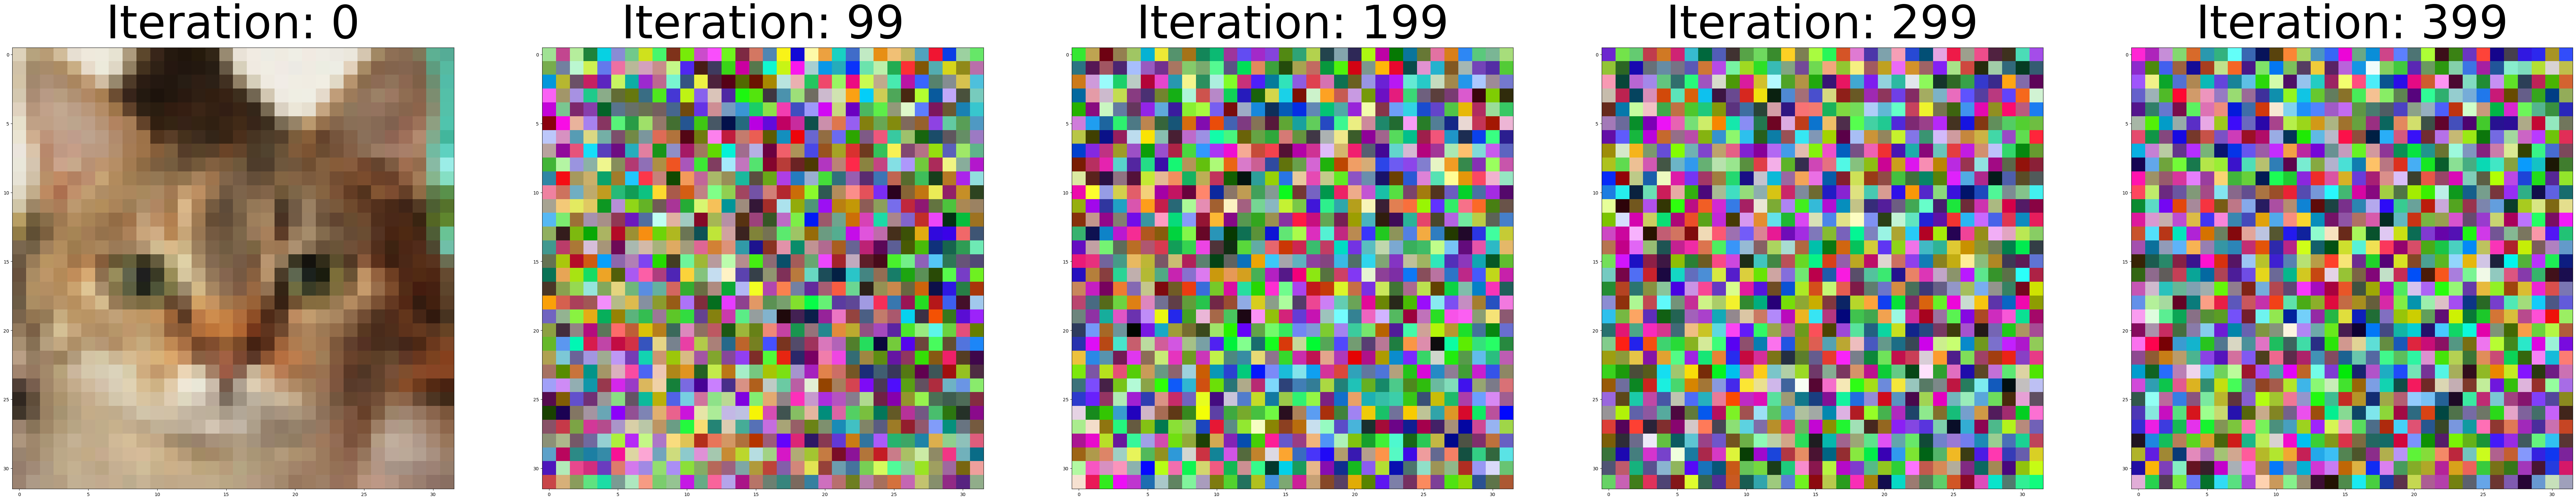

In [10]:
#lets see 5 images at some particular time
image_no = 5
batch_torch_image = torch.stack([diffusion_torch_image] * image_no)
t = torch.linspace(0, diffusion_model.timesteps - 1, image_no).long()
batch_noisy_image, _ = diffusion_model.forward(batch_torch_image, t, device)

plt.figure(figsize=(10,10))
f, a = plt.subplots(1, image_no, figsize = (100,100))

for i, img in enumerate(batch_noisy_image):
    a[i].imshow(reverse_transform(img))
    a[i].set_title(f"Iteration: {t[i].item()}", fontsize = 100)
plt.show()

In [11]:

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # Get the device of the input 'time' tensor
        device = time.device

        # Calculate half of the specified dimension for sine and cosine embeddings
        half_dim = self.dim // 2

        # Compute a scalar value for the embeddings
        embeddings = math.log(10000) / (half_dim - 1)

        # Calculate a tensor of exponential values for frequency representation
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)

        # Generate embeddings by multiplying 'time' with the frequency values
        embeddings = time[:, None] * embeddings[None, :]

        # Combine sine and cosine embeddings and concatenate them along the last dimension
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        # Return the computed sinusoidal position embeddings
        return embeddings

In [12]:
#These blocks are needed for the UNet architecture.

class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters=3, downsample=True):
        super().__init__()

        # Initialize the Block module with various parameters
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels

        # If labels are used, create a linear layer for label processing
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        # Create convolutional layers for downsample or upsample
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)#kernal stride and padding
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        # Batch normalization layers for feature normalization
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)

        # Linear layer for processing time embeddings
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)

        # Rectified Linear Unit (ReLU) activation function
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        # Apply the first convolutional layer and batch normalization
        out = self.bnorm1(self.relu(self.conv1(x)))

        # Process time embeddings using a linear layer and add to the output
        out_time = self.relu(self.time_mlp(self.time_embedding(t)))
        out = out + out_time[(..., ) + (None, ) * 2]

        # If labels are used, add processed labels to the output
        if self.labels:
            label = kwargs.get('labels')
            out_label = self.relu(self.label_mlp(label))
            out = out + out_label[(..., ) + (None, ) * 2]

        # Apply the second convolutional layer and batch normalization
        out = self.bnorm2(self.relu(self.conv2(out)))

        # Apply the final convolutional layer
        return self.final(out)

In [13]:
#The channel sizes are given in the sequence_channels

class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims #here we use the time embeddings
        sequence_channels_rev = reversed(sequence_channels)
        
        #The UP and DOWN sampling
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    # The forward
    def forward(self, x, t, **kwargs):
        residuals = []
        out = self.conv1(x)
        for down_sample in self.downsampling:
            out = down_sample(out, t, **kwargs)
            residuals.append(out)
        for up_sample, residual in zip(self.upsampling, reversed(residuals)):
            out = up_sample(torch.cat((out, residual), dim=1), t, **kwargs)
            
        return self.conv2(out)

In [14]:
#Information for training
total_epochs = 2000
print_frequency = 500
learning_rate = 0.001
batch_size = 128
information = True

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)

Epoch: 0 | Train Loss 1.0317939519882202


<Figure size 1000x1000 with 0 Axes>

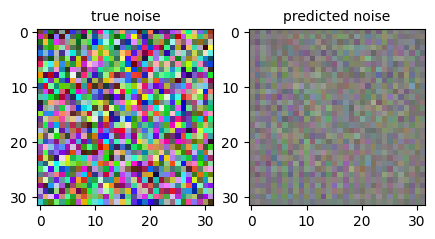

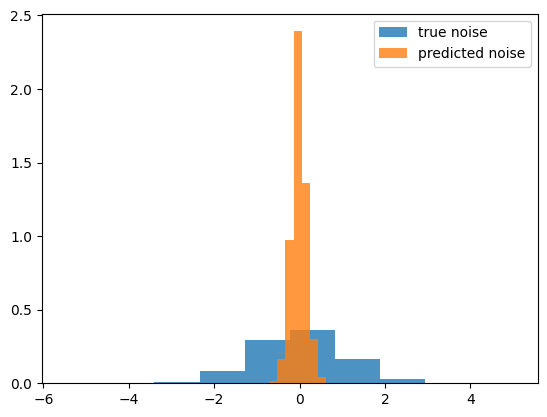

Epoch: 500 | Train Loss 0.011262591928243637


<Figure size 1000x1000 with 0 Axes>

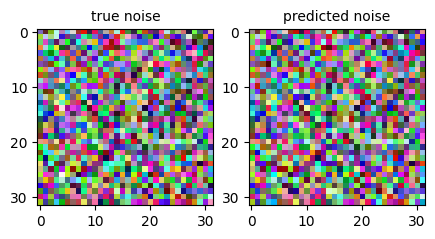

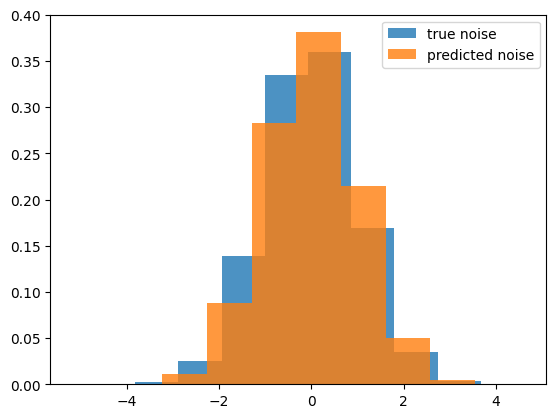

Epoch: 1000 | Train Loss 0.009885832667350769


<Figure size 1000x1000 with 0 Axes>

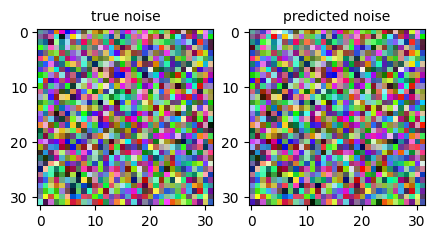

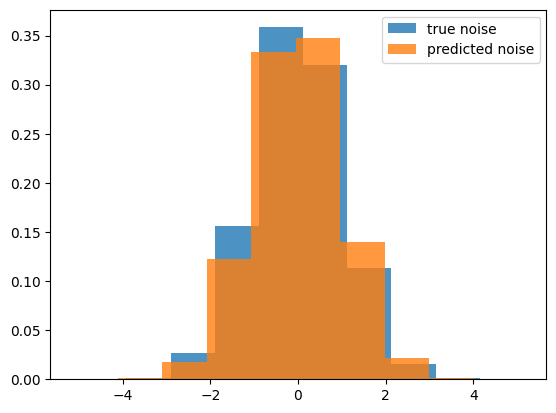

Epoch: 1500 | Train Loss 0.007045763544738293


<Figure size 1000x1000 with 0 Axes>

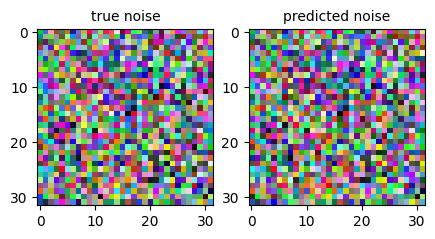

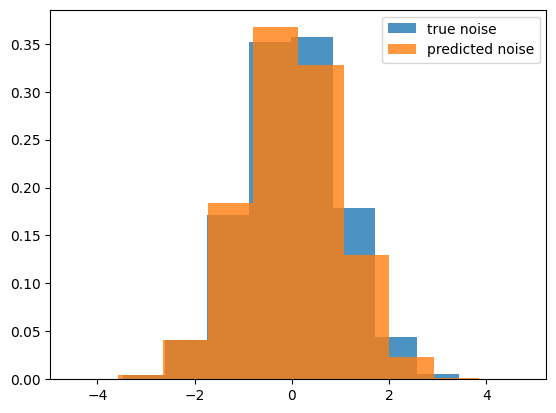

In [16]:
for epoch in range(total_epochs):
    mean_epoch_loss = []
    
    batch = torch.stack([diffusion_torch_image] * batch_size)
    t = torch.randint(0, diffusion_model.timesteps, (batch_size,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device) 
    predicted_noise = unet(batch_noisy, t)
    
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % print_frequency == 0:
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if information:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

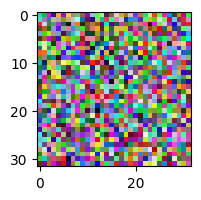

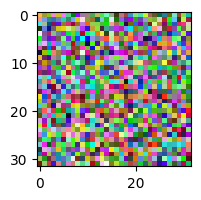

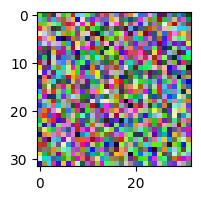

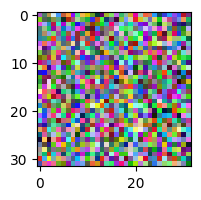

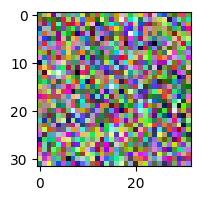

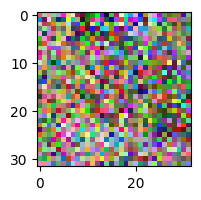

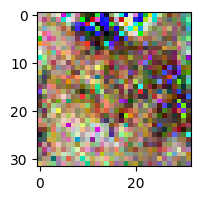

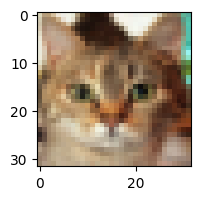

In [17]:
#Get back the image from the noise again
with torch.no_grad():
    img = torch.randn((1, 3) + image_shape).to(device) #start with a noise(same as the image size with randn)
    for i in reversed(range(diffusion_model.timesteps)): #for the reverse time step T->0
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())# do the backward
        if i % 50 == 0: #400/50=8 images
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()